In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import math 

def radial_basis_function(x, grid_pnts, widths):
    """_summary_

    Args:
        x (_type_): _description_
        grid_pnts (_type_): _description_
        widths (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Calculate the squared Euclidean distance between x and each center
    activations = torch.exp( - ((x - grid_pnts) / widths) ** 2)
    return activations


class RBFLayer(nn.Module):
    def __init__(self, width=None,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, 
                 trainable_center=False,
                 trainable_width=False):
        super(RBFLayer, self).__init__()
        grid = torch.linspace(grid_min, grid_max, grid_size)
        self.centers = nn.Parameter(grid, requires_grad=trainable_center)
        if width is None:
            width = (grid_max - grid_min) / (grid_size - 1)
        self.width = nn.Parameter(torch.tensor(width, dtype=torch.float32), requires_grad=trainable_width)

    def forward(self, x):
        activations = torch.exp( - ((x[..., None] - self.centers) / self.width)**2)
        return activations


class RBFKANLayer(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 output_dim : int,
                 residual=True,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, width=None,
                 trainable_center=False,
                 trainable_width=False):
        super(RBFKANLayer, self).__init__()
        self.rbf = RBFLayer(width, grid_min, grid_max, grid_size, trainable_center, trainable_width)
        basis_coef = torch.randn(input_dim, grid_size) / math.sqrt(input_dim)
        self.basis_coef = nn.Parameter(basis_coef, requires_grad=True)
        self.residual = residual
        if residual:
            self.res_act = nn.SiLU()
        self.readout = nn.Linear(input_dim, output_dim)
        # self.basis_combined = nn.Linear(input_dim * grid_size, output_dim)
        

    def forward(self, x):
        rbf_act = self.rbf(x) # [batch_size, input_dim, grid_size]
        rbf_act = einops.einsum(rbf_act, self.basis_coef, 'B inp grid, inp grid -> B inp')
        if self.residual:
            rbf_act = rbf_act + self.res_act(x)
        out = self.readout(rbf_act)
        return out
        

class RBFKANnet(nn.Module):
    def __init__(self, layer_dim_list, residual=True, KAN_config=None):
        super(RBFKANnet, self).__init__()
        self.layers = nn.ModuleList()
        if KAN_config is None:
            KAN_config = {'grid_min': -2.0, 'grid_max': 2.0, 'grid_size': 10, 'width': None,
                          'trainable_center': False, 'trainable_width': False}
        for i in range(len(layer_dim_list) - 1):
            self.layers.append(RBFKANLayer(layer_dim_list[i], layer_dim_list[i+1], 
                                           residual=residual, **KAN_config))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage
rbf_layer = RBFLayer()
input_data = torch.randn(10, 2)
output = rbf_layer(input_data)
print(output.shape)
layer = RBFKANLayer(500, 50)
data = torch.randn(15, 500)
output = layer(data)
print(output.shape)
net = RBFKANnet([500, 50, 10])
output = net(data)
print(output.shape)

torch.Size([10, 2, 10])
torch.Size([15, 50])
torch.Size([15, 10])


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

net = RBFKANnet([784, 50, 10])
MLP = nn.Sequential(
    nn.Linear(784, 64),
    nn.SiLU(),
    nn.Linear(64, 10)
)
print("Trainable parameters in RBFKANLayer:", count_parameters(layer))
print("Trainable parameters in RBFKANnet:", count_parameters(net))
print ("Trainable parameters in MLP:", count_parameters(MLP))

Trainable parameters in RBFKANLayer: 30050
Trainable parameters in RBFKANnet: 48100
Trainable parameters in MLP: 50890


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='~/Datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/Datasets', train=False, download=True, transform=transform)

In [23]:
def train(model, train_dataset, test_dataset, train_batch, eval_batch, device, num_epochs=10, lr=0.005, testset_names=None, verbose=True):
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    stats = {}
    epoch = -1
    stats[epoch] = {}
    if isinstance(test_dataset, list):
        for dataset, label in zip(test_dataset, testset_names):
            print(f"Evaluating on {label}", end="\t")
            eval_stats = eval_on_dataset(model, dataset, eval_batch, device)
            # add prefix to keys
            eval_stats = {f"{label}_{k}": v for k, v in eval_stats.items()}
            stats[epoch].update(eval_stats)
    else:
        eval_stats = eval_on_dataset(model, test_dataset, eval_batch, device)
        stats[epoch].update(eval_stats)
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 and verbose:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Evaluate on the test set
        stats[epoch] = {}
        if isinstance(test_dataset, list):
            for dataset, label in zip(test_dataset, testset_names):
                print(f"Evaluating on {label}", end="\t")
                eval_stats = eval_on_dataset(model, dataset, eval_batch, device, verbose)
                # add prefix to keys
                eval_stats = {f"{label}_{k}": v for k, v in eval_stats.items()}
                stats[epoch].update(eval_stats)
        else:
            eval_stats = eval_on_dataset(model, test_dataset, eval_batch, device, verbose)
            stats[epoch].update(eval_stats)
        
    return model, stats

def eval_on_dataset(model, dataset, batch_size, device, verbose=True):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataset)
    if verbose:
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(dataset)} '
            f'({100. * correct / len(dataset):.0f}%)')
    acc = correct / len(dataset)
    return {"loss": test_loss, "accuracy": acc}

### Define separate dataset for different digit in MNIST

In [6]:
from torch.utils.data import TensorDataset
def extract_digits(dataset, digits, ):
    indices = [i for i, label in enumerate(dataset.targets) if label in digits]
    x_selected = [dataset[i][0] for i in indices]
    x_selected = torch.stack(x_selected)
    y_selected = dataset.targets[indices]
    # Create a mapping from the original labels to the new labels
    digit_map = {digit: idx for idx, digit in enumerate(digits)}
    y_selected = torch.tensor([digit_map[label.item()] for label in y_selected])
    return TensorDataset(x_selected, y_selected)

data012 = extract_digits(train_dataset, [0, 1, 2], )
data012_test = extract_digits(test_dataset, [0, 1, 2], )
data345 = extract_digits(train_dataset, [3, 4, 5], )
data345_test = extract_digits(test_dataset, [3, 4, 5], )
data6789 = extract_digits(train_dataset, [6, 7, 8, 9], )
data6789_test = extract_digits(test_dataset, [6, 7, 8, 9], )

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def compile_stats_to_df(*args):
    dfs = [pd.DataFrame(stats).T for stats in args]
    df_all = pd.concat(dfs, axis=0)
    df_all = df_all.reset_index().rename(columns={"index": "local_epoch"})
    return df_all


In [16]:
def visualize_continual_learning(df_all, model_name="KAN"):
    plt.plot(df_all["012_accuracy"], label="012")
    plt.plot(df_all["345_accuracy"], label="345")
    plt.plot(df_all["6789_accuracy"], label="6789")
    plt.legend()
    plt.axvline(x=11, color="red", linestyle="--")
    plt.axvline(x=22, color="red", linestyle="--")
    plt.xlabel("Global epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} continual learning on MNIST partitions")
    plt.show()
    plt.plot(df_all["012_loss"], label="012")
    plt.plot(df_all["345_loss"], label="345")
    plt.plot(df_all["6789_loss"], label="6789")
    plt.legend()
    plt.axvline(x=11, color="red", linestyle="--")
    plt.axvline(x=22, color="red", linestyle="--")
    plt.xlabel("Global epoch")
    plt.ylabel("Test Loss")
    plt.title(f"{model_name} continual learning on MNIST partitions")
    plt.show()
    

Evaluating on 012	Test set: Average loss: 0.0007, Accuracy: 0/3147 (0%)
Evaluating on 345	Test set: Average loss: 0.0008, Accuracy: 0/2884 (0%)
Evaluating on 6789	Test set: Average loss: 0.0006, Accuracy: 1004/3969 (25%)
Train Epoch: 0 [0/18623 (0%)]	Loss: 2.353984
Evaluating on 012	Test set: Average loss: 0.0001, Accuracy: 2896/3147 (92%)
Evaluating on 345	Test set: Average loss: 0.0006, Accuracy: 688/2884 (24%)
Evaluating on 6789	Test set: Average loss: 0.0009, Accuracy: 1032/3969 (26%)
Train Epoch: 1 [0/18623 (0%)]	Loss: 0.284298
Evaluating on 012	Test set: Average loss: 0.0000, Accuracy: 3008/3147 (96%)
Evaluating on 345	Test set: Average loss: 0.0010, Accuracy: 597/2884 (21%)
Evaluating on 6789	Test set: Average loss: 0.0013, Accuracy: 1088/3969 (27%)
Train Epoch: 2 [0/18623 (0%)]	Loss: 0.134935
Evaluating on 012	Test set: Average loss: 0.0000, Accuracy: 3052/3147 (97%)
Evaluating on 345	Test set: Average loss: 0.0012, Accuracy: 578/2884 (20%)
Evaluating on 6789	Test set: Average 

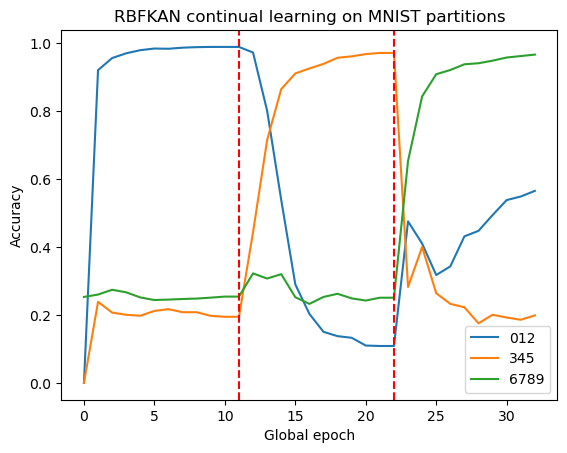

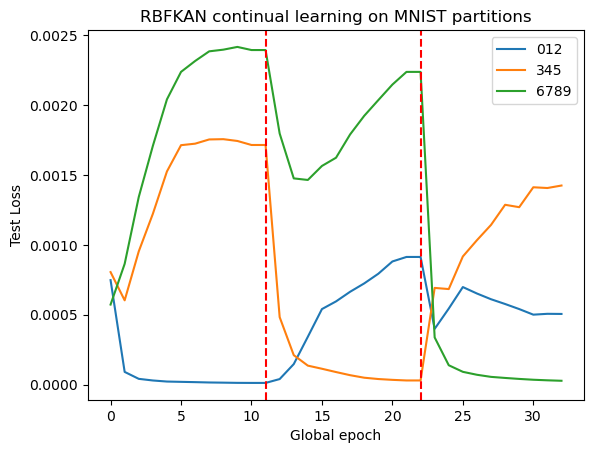

In [17]:
device = "cuda"
model = RBFKANnet([28 * 28, 50, 10]).to(device)
model, stats1 = train(model, data012, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.01, testset_names=["012", "345", "6789"])
model, stats2 = train(model, data345, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.01, testset_names=["012", "345", "6789"])
model, stats3 = train(model, data6789, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.01, testset_names=["012", "345", "6789"])
df_all = compile_stats_to_df(stats1, stats2, stats3)
visualize_continual_learning(df_all, "RBFKAN")

Evaluating on 012	Test set: Average loss: 0.0008, Accuracy: 25/3147 (1%)
Evaluating on 345	Test set: Average loss: 0.0008, Accuracy: 32/2884 (1%)
Evaluating on 6789	Test set: Average loss: 0.0006, Accuracy: 76/3969 (2%)
Train Epoch: 0 [0/18623 (0%)]	Loss: 2.367660
Evaluating on 012	Test set: Average loss: 0.0002, Accuracy: 2253/3147 (72%)
Evaluating on 345	Test set: Average loss: 0.0006, Accuracy: 641/2884 (22%)
Evaluating on 6789	Test set: Average loss: 0.0009, Accuracy: 924/3969 (23%)
Train Epoch: 1 [0/18623 (0%)]	Loss: 0.501107
Evaluating on 012	Test set: Average loss: 0.0001, Accuracy: 2812/3147 (89%)
Evaluating on 345	Test set: Average loss: 0.0008, Accuracy: 624/2884 (22%)
Evaluating on 6789	Test set: Average loss: 0.0013, Accuracy: 1433/3969 (36%)
Train Epoch: 2 [0/18623 (0%)]	Loss: 0.293644
Evaluating on 012	Test set: Average loss: 0.0000, Accuracy: 2974/3147 (95%)
Evaluating on 345	Test set: Average loss: 0.0009, Accuracy: 944/2884 (33%)
Evaluating on 6789	Test set: Average lo

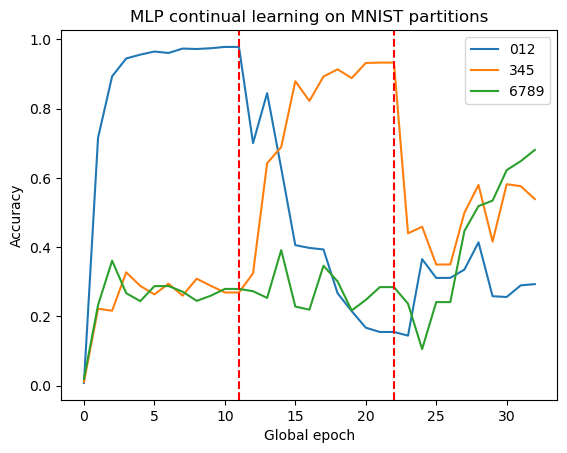

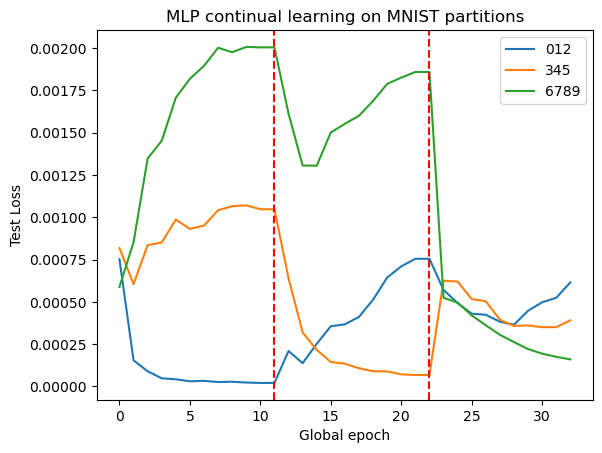

In [18]:
device = "cuda"
MLP = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.SiLU(),
    nn.Linear(64, 10)
).to(device)
MLP, stats1_MLP = train(MLP, data012, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.01, testset_names=["012", "345", "6789"])
MLP, stats2_MLP = train(MLP, data345, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.01, testset_names=["012", "345", "6789"])
MLP, stats3_MLP = train(MLP, data6789, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.01, testset_names=["012", "345", "6789"])
df_all_MLP = compile_stats_to_df(stats1_MLP, stats2_MLP, stats3_MLP)
visualize_continual_learning(df_all_MLP, "MLP")

Evaluating on 012	Test set: Average loss: 0.0007, Accuracy: 898/3147 (29%)
Evaluating on 345	Test set: Average loss: 0.0008, Accuracy: 983/2884 (34%)
Evaluating on 6789	Test set: Average loss: 0.0006, Accuracy: 724/3969 (18%)
Train Epoch: 0 [0/18623 (0%)]	Loss: 2.311963
Evaluating on 012	Test set: Average loss: 0.0003, Accuracy: 2878/3147 (91%)
Evaluating on 345	Test set: Average loss: 0.0004, Accuracy: 879/2884 (30%)
Evaluating on 6789	Test set: Average loss: 0.0005, Accuracy: 1139/3969 (29%)
Train Epoch: 1 [0/18623 (0%)]	Loss: 0.968556
Evaluating on 012	Test set: Average loss: 0.0002, Accuracy: 2938/3147 (93%)
Evaluating on 345	Test set: Average loss: 0.0004, Accuracy: 894/2884 (31%)
Evaluating on 6789	Test set: Average loss: 0.0006, Accuracy: 1082/3969 (27%)
Train Epoch: 2 [0/18623 (0%)]	Loss: 0.700500
Evaluating on 012	Test set: Average loss: 0.0002, Accuracy: 2948/3147 (94%)
Evaluating on 345	Test set: Average loss: 0.0004, Accuracy: 853/2884 (30%)
Evaluating on 6789	Test set: Ave

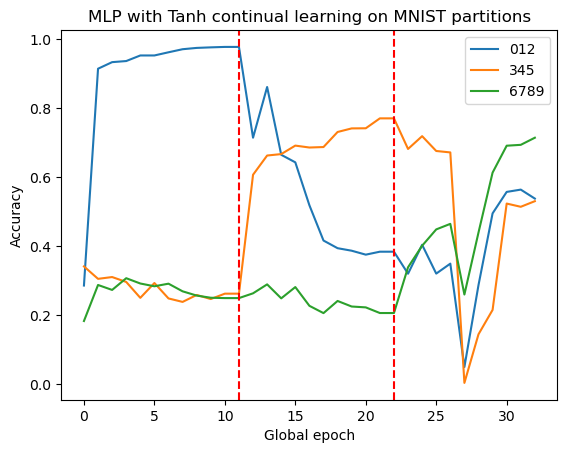

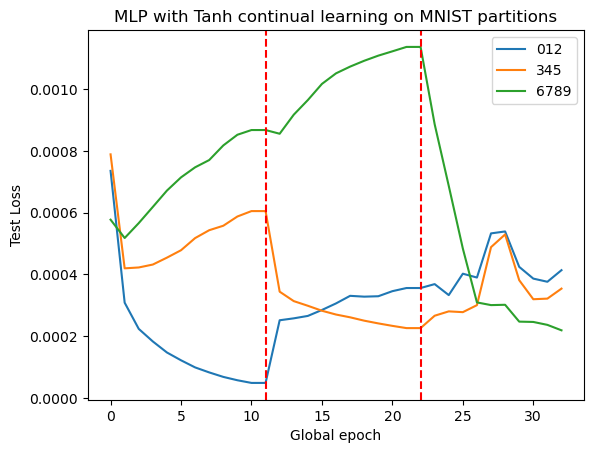

In [19]:
device = "cuda"
MLP = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.Tanh(),
    nn.Linear(64, 10)
).to(device)
MLP, stats1_MLP_tanh = train(MLP, data012, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.005, testset_names=["012", "345", "6789"])
MLP, stats2_MLP_tanh = train(MLP, data345, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.005, testset_names=["012", "345", "6789"])
MLP, stats3_MLP_tanh = train(MLP, data6789, [data012_test, data345_test, data6789_test], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.005, testset_names=["012", "345", "6789"])
df_all_MLP_tanh = compile_stats_to_df(stats1_MLP_tanh, stats2_MLP_tanh, stats3_MLP_tanh)
visualize_continual_learning(df_all_MLP_tanh, model_name="MLP with Tanh")

### Image Input

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset_img = datasets.MNIST(root='~/Datasets', train=True, download=True, transform=transform)
test_dataset_img = datasets.MNIST(root='~/Datasets', train=False, download=True, transform=transform)

data012_img = extract_digits(train_dataset_img, [0, 1, 2], )
data012_test_img = extract_digits(test_dataset_img, [0, 1, 2], )
data345_img = extract_digits(train_dataset_img, [3, 4, 5], )
data345_test_img = extract_digits(test_dataset_img, [3, 4, 5], )
data6789_img = extract_digits(train_dataset_img, [6, 7, 8, 9], )
data6789_test_img = extract_digits(test_dataset_img, [6, 7, 8, 9], )

Evaluating on 012	Test set: Average loss: 0.0007, Accuracy: 1032/3147 (33%)
Evaluating on 345	Test set: Average loss: 0.0008, Accuracy: 892/2884 (31%)
Evaluating on 6789	Test set: Average loss: 0.0006, Accuracy: 974/3969 (25%)
Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Evaluating on 345	Evaluating on 6789	Evaluating on 012	Test set: Average loss: 0.0000, Accuracy: 3092/3147 (98%)
Evaluating on 345	Test set: Average loss: 0.0014, Accuracy: 746/2884 (26%)
Evaluating on 6789	Test set: Average loss: 0.0016, Accuracy: 1143/3969 (

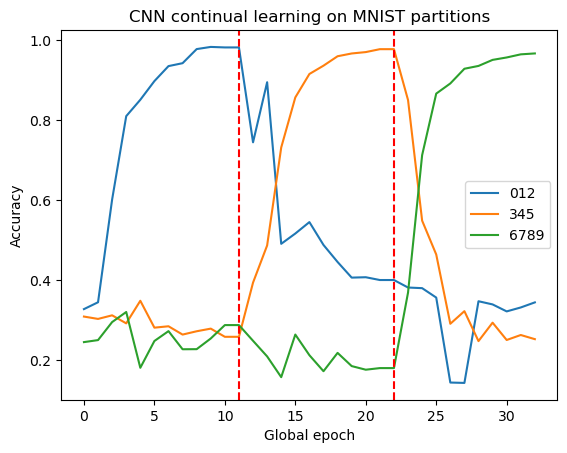

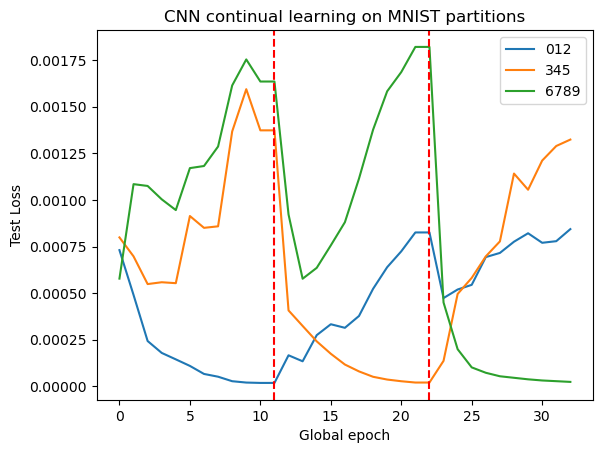

In [26]:
device = "cuda"
CNN_3L = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.SiLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
    nn.SiLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
    nn.SiLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(128, 10)
).to(device)
CNN_3L, stats1_CNN = train(CNN_3L, data012_img, [data012_test_img, data345_test_img, data6789_test_img], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.005, testset_names=["012", "345", "6789"], verbose=False)
CNN_3L, stats2_CNN = train(CNN_3L, data345_img, [data012_test_img, data345_test_img, data6789_test_img], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.005, testset_names=["012", "345", "6789"], verbose=False)
CNN_3L, stats3_CNN = train(CNN_3L, data6789_img, [data012_test_img, data345_test_img, data6789_test_img], train_batch=5000, eval_batch=10000, device="cuda", num_epochs=10, lr=0.005, testset_names=["012", "345", "6789"], verbose=False)
df_all_CNN_3L = compile_stats_to_df(stats1_CNN, stats2_CNN, stats3_CNN)
visualize_continual_learning(df_all_CNN_3L, model_name="CNN")

In [27]:

print ("Trainable parameters in CNN:", count_parameters(CNN_3L))

Trainable parameters in CNN: 93962


### Scratch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='~/Datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/Datasets', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RBFKANnet([28 * 28, 50, 10]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Evaluate on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309544

Test set: Average loss: 0.0004, Accuracy: 8960/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.355956

Test set: Average loss: 0.0003, Accuracy: 9243/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.275057

Test set: Average loss: 0.0002, Accuracy: 9375/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.200089

Test set: Average loss: 0.0002, Accuracy: 9447/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.214981

Test set: Average loss: 0.0002, Accuracy: 9521/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.147768

Test set: Average loss: 0.0001, Accuracy: 9563/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.134384

Test set: Average loss: 0.0001, Accuracy: 9603/10000 (96%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.113770

Test set: Average loss: 0.0001, Accuracy: 9642/10000 (96%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.099980

Test set: Average loss: 0.0001, Accuracy: 9663/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.082237



In [ ]:
model = RBFKANnet([28 * 28, 50, 10]).to(device)
train(model, train_dataset, test_dataset, train_batch=2048, eval_batch=5000, device="cuda", num_epochs=10, lr=0.005)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.066652

Test set: Average loss: 0.0000, Accuracy: 9664/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.060082

Test set: Average loss: 0.0000, Accuracy: 9671/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.051811

Test set: Average loss: 0.0000, Accuracy: 9691/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.041368

Test set: Average loss: 0.0000, Accuracy: 9688/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.039568

Test set: Average loss: 0.0000, Accuracy: 9677/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.032715

Test set: Average loss: 0.0000, Accuracy: 9690/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.033347

Test set: Average loss: 0.0000, Accuracy: 9700/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.028179

Test set: Average loss: 0.0000, Accuracy: 9692/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.027380

Test set: Average loss: 0.0000, Accuracy: 9695/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.019722



RBFKANnet(
  (layers): ModuleList(
    (0): RBFKANLayer(
      (rbf): RBFLayer()
      (res_act): SiLU()
      (readout): Linear(in_features=784, out_features=50, bias=True)
    )
    (1): RBFKANLayer(
      (rbf): RBFLayer()
      (res_act): SiLU()
      (readout): Linear(in_features=50, out_features=10, bias=True)
    )
  )
)

In [ ]:
MLP = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.SiLU(),
    nn.Linear(64, 10)
)
train(MLP, train_dataset, test_dataset, train_batch=2048, eval_batch=5000, device="cuda", num_epochs=25, lr=0.005)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.322063

Test set: Average loss: 0.0001, Accuracy: 8777/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.395896

Test set: Average loss: 0.0001, Accuracy: 9064/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.360773

Test set: Average loss: 0.0001, Accuracy: 9130/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.328451

Test set: Average loss: 0.0001, Accuracy: 9210/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.306554

Test set: Average loss: 0.0001, Accuracy: 9303/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.245835

Test set: Average loss: 0.0000, Accuracy: 9327/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.212305

Test set: Average loss: 0.0000, Accuracy: 9347/10000 (93%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.231029

Test set: Average loss: 0.0000, Accuracy: 9448/10000 (94%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.175529

Test set: Average loss: 0.0000, Accuracy: 9449/10000 (94%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.144383



Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): SiLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)